In [138]:
# Predict the price of the Uber ride from a given pickup point to the agreed drop-off 
# location. Perform following tasks:  
# 1. Pre-process the dataset.  
# 2. Identify outliers.  
# 3. Check the correlation.  
# 4. Implement linear regression and ridge, Lasso regression models.  
# 5. Evaluate the models and compare their respective scores like R2, RMSE, etc. 

In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from math import radians, cos, sin, asin, sqrt


In [140]:
uber = pd.read_csv('uber.csv')
uber.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [141]:
print("Number of columns: ", uber.shape[1])
print("Number of rows: ", uber.shape[0])

Number of columns:  9
Number of rows:  200000


In [142]:
uber.columns

Index(['Unnamed: 0', 'key', 'fare_amount', 'pickup_datetime',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count'],
      dtype='object')

In [143]:
uber.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [144]:
print("Missing values: ", uber.isnull().sum())

Missing values:  Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64


In [145]:
uber = uber.drop(['Unnamed: 0', 'key'], axis=1)
uber.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [146]:
uber['pickup_datetime'] = pd.to_datetime(uber['pickup_datetime'], errors='coerce')

In [147]:
uber = uber.dropna(subset=['pickup_datetime'])

In [148]:
uber = uber.dropna(subset=['dropoff_longitude', 'dropoff_latitude'])

In [149]:
# Data Engineering
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    km = 6371 * c
    return km

In [150]:
uber['distance_km'] = uber.apply(lambda row: haversine(
    row['pickup_longitude'], row['pickup_latitude'],
    row['dropoff_longitude'], row['dropoff_latitude']), axis=1)

In [151]:
uber['hour'] = uber['pickup_datetime'].dt.hour
uber['day'] = uber['pickup_datetime'].dt.dayofweek   # Monday=0, Sunday=6
uber['month'] = uber['pickup_datetime'].dt.month

In [152]:
#Outliers
uber = uber[(uber['fare_amount'] > 0) & (uber['fare_amount'] < 500)]
uber = uber[(uber['passenger_count'] > 0) & (uber['passenger_count'] <= 6)]
uber = uber[(uber['distance_km'] < 100)]

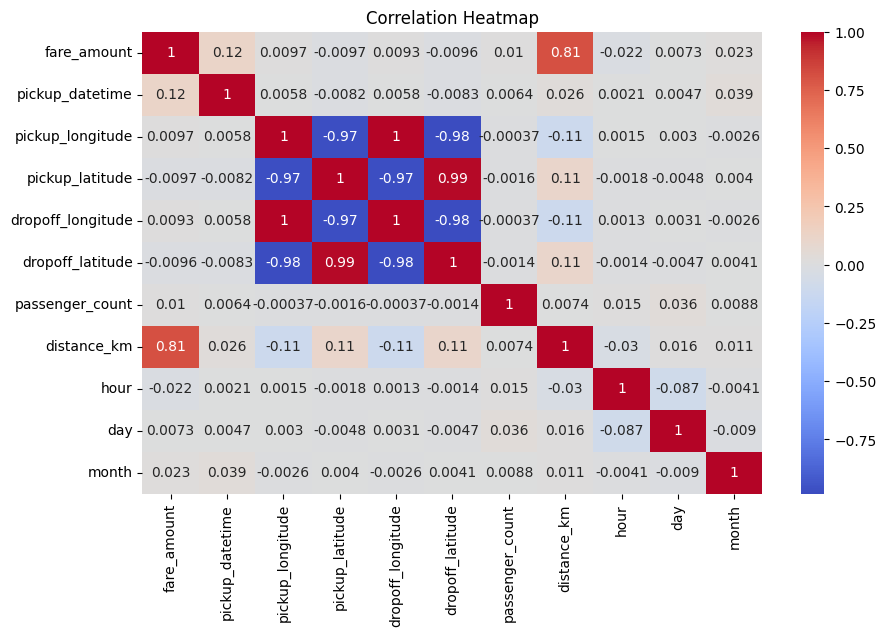

In [153]:
plt.figure(figsize=(10,6))
sns.heatmap(uber.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [154]:
# Prepare Data
X = uber[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 
          'dropoff_latitude', 'passenger_count', 'distance_km', 
          'hour', 'day', 'month']]
y = uber['fare_amount']

In [155]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [156]:
#Train models
lr = LinearRegression()
ridge = Ridge(alpha=1.0)
lasso = Lasso(alpha=0.1)

lr.fit(X_train, y_train)
ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)

Lasso(alpha=0.1)

In [157]:
#Predictions
y_pred_lr = lr.predict(X_test)
y_pred_ridge = ridge.predict(X_test)
y_pred_lasso = lasso.predict(X_test)

In [158]:
# Evaluate models
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} --> RMSE: {rmse:.2f}, R2: {r2:.3f}")

In [159]:
evaluate_model(y_test, y_pred_lr, "Linear Regression")
evaluate_model(y_test, y_pred_ridge, "Ridge Regression")
evaluate_model(y_test, y_pred_lasso, "Lasso Regression")

Linear Regression --> RMSE: 5.48, R2: 0.695
Ridge Regression --> RMSE: 5.48, R2: 0.695
Lasso Regression --> RMSE: 5.51, R2: 0.691
